# Solve the problem

In [32]:
# read a mesh from file
from mpi4py import MPI
from dolfinx.io import gmshio
from mesh_generation import generate_mesh_from_geo
generate_mesh_from_geo("data/meshes/1.geo")
domain, cell_tags, facet_tags = gmshio.read_from_msh("data/meshes/1.msh", MPI.COMM_WORLD, 0, gdim=2)

Info    : Reading 'data/meshes/1.geo'...
Info    : Meshing 1D...ence - Adding holes                                                                                
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Circle)
Info    : [ 80%] Meshing curve 10 (Circle)
Info    : [ 90%] Meshing curve 11 (Circle)
Info    : [100%] Meshing curve 12 (Circle)
Info    : Done meshing 1D (Wall 0.590816s, CPU 0.551328s)
Info    : Meshing 2D...
Info    : Meshing surface 3 (BSpline surface, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.551486s, CPU 0.512693s)
Info    : 7217 nodes 14447 elements
Info    : Done reading 'data/meshes/1.geo'
Info    : Meshing 2D...
Info    : Meshing surface 3 (BSpline s

In [68]:
# define finite element function space
from dolfinx.fem import functionspace
import numpy as np
V = functionspace(domain, ("Lagrange", 1))

# identify the boundary (create facet to cell connectivity required to determine boundary facets)
from dolfinx import default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

# Find facets marked with 2 and 3 (the two rectangles)
facets_rect1 = np.concatenate([facet_tags.find(10), facet_tags.find(11)])
facets_rect2 = facet_tags.find(12)

# Locate degrees of freedom
dofs_rect1 = locate_dofs_topological(V, fdim, facets_rect1)
dofs_rect2 = locate_dofs_topological(V, fdim, facets_rect2)

# Define different Dirichlet values
u_rect1 = Constant(domain, 0.0)
u_rect2 = Constant(domain, 1.0)

# Create BCs
bc1 = dirichletbc(u_rect1, dofs_rect1, V)
bc2 = dirichletbc(u_rect2, dofs_rect2, V)

bcs = [bc1, bc2]

# trial and test functions
import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# source term
from dolfinx import default_scalar_type
from dolfinx import fem
f = fem.Constant(domain, default_scalar_type(0.0))

# variational problem
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

# assemble the system
from dolfinx.fem.petsc import LinearProblem
problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [69]:
import ufl

# Define the vector function space for the gradient
V_vec = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))

# Define the trial and test functions for the vector space
u_vec = ufl.TrialFunction(V_vec)
v_vec = ufl.TestFunction(V_vec)

# Define the gradient of the solution
grad_u = ufl.grad(uh)

# Define the bilinear and linear forms
a_grad = ufl.inner(u_vec, v_vec) * ufl.dx
L_grad = ufl.inner(grad_u, v_vec) * ufl.dx

# Assemble the system
from dolfinx.fem.petsc import LinearProblem
problem_grad = LinearProblem(a_grad, L_grad, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
grad_uh = problem_grad.solve()

In [70]:
# Step 1: Find facets with tag 10
facets10 = facet_tags.find(10)
dofs10 = locate_dofs_topological(V, fdim, facets10)

# Step 2: Extract the x-coordinates and the y-coordinates of the DOFs
x_dofs = V.tabulate_dof_coordinates()[dofs10]
x_coords = x_dofs[:, 0]
print(x_coords.size)
#print(x_coords)
y_coords = x_dofs[:, 1]
print(y_coords.size)
#print(y_coords)

# Step 3: Evaluate grad_uh at those DOFs
dim = domain.geometry.dim
grad_x_uh_values = grad_uh.x.array[0::dim]
grad_y_uh_values = grad_uh.x.array[1::dim]
grad_x_uh_plate = grad_x_uh_values[dofs10]
grad_y_uh_plate = grad_y_uh_values[dofs10]
print(grad_x_uh_plate.size)
#print(grad_y_uh_plate)


350
350
350


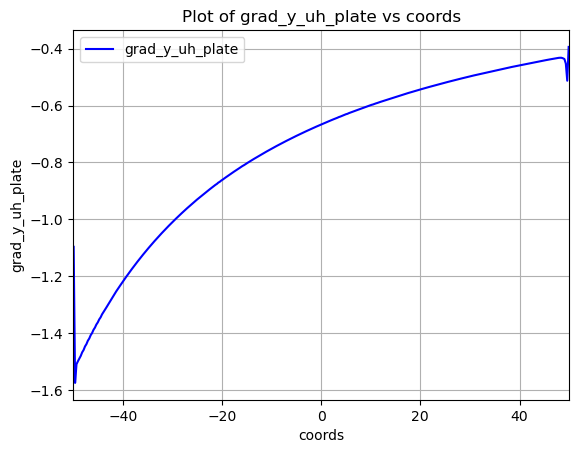

In [71]:
import matplotlib.pyplot as plt
import csv
# Plot grad_y_uh_plate against x_coords

# Sort x_coords and apply the same ordering to grad_y_uh_plate
# Read the value from the CSV file
import pandas as pd
parameters = pd.read_csv("data/parameters.csv")
center_y = parameters.iloc[0, 2]/2
center_x = 0.0

coords = np.sign(x_coords) * np.sqrt((x_coords-center_x)**2 + (y_coords-center_y)**2)
sorted_indices = np.argsort(coords)
coords = coords[sorted_indices]

grad_y_uh_plate = grad_y_uh_plate[sorted_indices]
grad_x_uh_plate = grad_x_uh_plate[sorted_indices]

plt.plot(coords, grad_y_uh_plate, label="grad_y_uh_plate", color="blue", linestyle="-")
plt.xlim(-50, 50)
plt.xlabel("coords")
plt.ylabel("grad_y_uh_plate")
plt.title("Plot of grad_y_uh_plate vs coords")
plt.legend()
plt.grid(True)
plt.show()

# Write all grad_y_uh_plate values in line 0 beginning from column 5

with open("data/parameters.csv", "r", newline="") as file:
    reader = csv.reader(file)
    rows = list(reader)

# Modify the first row to include grad_y_uh_plate values starting from column 5
rows[1] = rows[1][:5] + grad_y_uh_plate.tolist()

# Write the modified rows back to the file
with open("data/parameters.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(rows)

# Plot

In [60]:
# plot the mesh 
import pyvista
pyvista.OFF_SCREEN = False
print(pyvista.global_theme.jupyter_backend)

from dolfinx import plot
pyvista.start_xvfb()
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")


trame


Widget(value='<iframe src="http://localhost:40321/index.html?ui=P_0x7f5d90385f60_7&reconnect=auto" class="pyvi…

In [8]:
# plot the solution
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=False, cmap="bwr")
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

Widget(value='<iframe src="http://localhost:40321/index.html?ui=P_0x7f5dc404bd60_1&reconnect=auto" class="pyvi…

In [9]:
# plot the solution
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = grad_x_uh_values.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=False, cmap="bwr")
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

Widget(value='<iframe src="http://localhost:40321/index.html?ui=P_0x7f5dbffceaa0_2&reconnect=auto" class="pyvi…

In [10]:
# plot the solution
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = grad_y_uh_values.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=False, cmap="bwr")
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

Widget(value='<iframe src="http://localhost:40321/index.html?ui=P_0x7f5db4776a70_3&reconnect=auto" class="pyvi…

In [11]:
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=False, show_scalar_bar=True, cmap="coolwarm")
if not pyvista.OFF_SCREEN:
    plotter2.show()

Widget(value='<iframe src="http://localhost:40321/index.html?ui=P_0x7f5d7bff6aa0_4&reconnect=auto" class="pyvi…

# Save results

In [12]:
from dolfinx import io
from pathlib import Path
results_folder = Path("data/results")
results_folder.mkdir(exist_ok=True, parents=True)
filename = results_folder / "fundamentals"
""" with io.VTXWriter(domain.comm, filename.with_suffix(".bp"), [uh]) as vtx:
    vtx.write(0.0) """
with io.VTKFile(domain.comm, filename.with_suffix(".pvd"), "w") as vtk:
    vtk.write_mesh(domain)
    vtk.write_function(uh)
with io.XDMFFile(domain.comm, filename.with_suffix(".xdmf"), "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh)

In [ ]:
#Save solution in h5 file
import h5py

# Step 1: Find facets with tag 30(domain)
cells30 = cell_tags.find(30)
dofs30 = locate_dofs_topological(V, fdim, cells30)
#print(dofs30)
# Step 2: Extract the x-coordinates and the y-coordinates of the DOFs
dofs = V.tabulate_dof_coordinates()[dofs30]

x_coords = dofs[:, 0]
print(x_coords.size)
#print(x_coords)
y_coords = dofs[:, 1]
print(y_coords.size)
#print(y_coords)

# Step 3: Evaluate the function at those DOFs
dim = domain.geometry.dim
fval = np.array(uh.x.array[dofs30])
fval_x = f.x.array[0::dim]
fval_y = f.x.array[1::dim]
fval_x_plate = np.array(fval_x[dofs30])
fval_y_plate = np.array(fval_y[dofs30])

with h5py.File("mesh_data.h5", "w") as file:
    file.create_dataset("coordinates", data=x_dofs)
    file.create_dataset("potential_value", data=fval)
    file.create_dataset("field_value_x", data=fval_x_plate)
    file.create_dataset("field_value_y", data=fval_y_plate)

[   0    1    2 ... 1637 1642 1646]
1618
1618


In [14]:
# Test the h5 file
import h5py

def explore_h5(filename):
    with h5py.File(filename, "r") as f:
        print("Contents of HDF5 file:")
        def print_structure(name, obj):
            print(f" - {name} ({type(obj)})")
        f.visititems(print_structure)

        # Preview dataset content
        if "function_value" in f:
            data = f["function_value"][:]
            print("\nSample data from 'function_value':")
            print(data)
        if "function_value_x" in f:
            data = f["function_value_x"][:]
            print("\nSample data from 'function_value_x':")
            print(data)
        if "function_value_y" in f:
            data = f["function_value_y"][:]
            print("\nSample data from 'function_value_y':")
            print(data)

explore_h5("mesh_data.h5")

Contents of HDF5 file:
 - coordinates (<class 'h5py._hl.dataset.Dataset'>)
 - function_value_x (<class 'h5py._hl.dataset.Dataset'>)
 - function_value_y (<class 'h5py._hl.dataset.Dataset'>)

Sample data from 'function_value_x':
[ 3.46260793e-17  1.04083409e-17 -5.54444426e-17 ... -4.88807712e-04
  2.25528950e-04  1.07380048e-03]

Sample data from 'function_value_y':
[-0.5        -0.5        -0.5        ... -0.00347035 -0.00102748
  0.00458448]
